In [3]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cgeniepy.foram import ForamModel as fm
import numpy as np

def biomass_int(model_path):
    model = fm(model_path)
    time = model.select_var("time").array.values - 4.5
    foram_names = ["bn", "bs", "sn", "ss"]
    data = []

    for iyear in range(len(time)):
        state_foram = 0
        for foram in foram_names:
            state_foram += model.select_foramtype(foram).biomass().isel(time=iyear).sum().magnitude
        data.append(state_foram)
    return time, data


def cal_ratio(a1, a2, thershold):
    ratio = np.divide(a1, a2, out=np.zeros_like(a1))
    ratio = (ratio - 1)*100
    ## if any value is smaller than threshold, set the ratio to 0
    ratio[np.where(a2 < thershold)] = 0
    return ratio

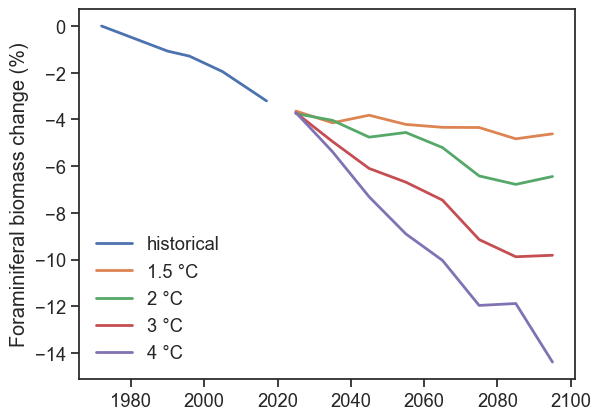

In [7]:
## plot pre-industrial age to future
mod_paths = [
    "../model/muffin.CBE.worlg4.BASESFeTDTL.historical",
    "../model/muffin.CBE.worlg4.BASESFeTDTL.2100.1p5deg",
    "../model/muffin.CBE.worlg4.BASESFeTDTL.2100.2deg",
    "../model/muffin.CBE.worlg4.BASESFeTDTL.2100.3deg",
    "../model/muffin.CBE.worlg4.BASESFeTDTL.2100.4deg",
]


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Store the temporary dataframes in a list
dfs = []

# Iterate over each model path and retrieve the data
for path in mod_paths:
    time_data, biomass_data = biomass_int(path)

    # Create a temporary dataframe for each model's data
    temp_df = pd.DataFrame({"time": time_data, "biomass": biomass_data})
    temp_df['age'] = path.split(".")[-1]
    temp_df['age'] = temp_df['age'].str.replace("deg", " °C")
    temp_df['age'] = temp_df['age'].str.replace("1p5", "1.5")

    dfs.append(temp_df)

# Concatenate the dataframes from the list
merged_df = pd.concat(dfs, ignore_index=True)

# Filter data after 1900
merged_df = merged_df[merged_df['time'] > 1900]

# Calculate biomass change relative to pre-industrial and convert to percentage
merged_df['biomass'] = merged_df['biomass'] / merged_df['biomass'].iloc[0] * 100 - 100

# Plot the data using seaborn
sns.set_theme(style='ticks')
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2})
sns.lineplot(data=merged_df, x="time", y="biomass", hue="age")
plt.ylabel("Foraminiferal biomass change (%)")
plt.xlabel("")
plt.legend(title="", frameon=False)

## export figure
plt.savefig("../output/foram_biomass_ts.jpg", dpi=300, bbox_inches="tight")
# Show the plot
plt.show()

/var/folders/rq/vks10_qx2l9b08d_pygvwfzh0000gn/T/ipykernel_1654/69110126.py:21: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(a1, a2, out=np.zeros_like(a1))
/var/folders/rq/vks10_qx2l9b08d_pygvwfzh0000gn/T/ipykernel_1654/69110126.py:21: RuntimeWarning: invalid value encountered in divide
  ratio = np.divide(a1, a2, out=np.zeros_like(a1))


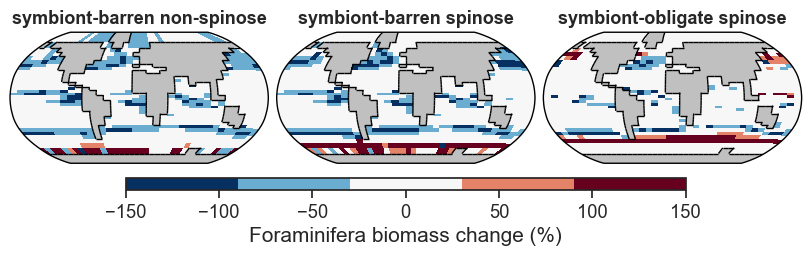

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cgeniepy.foram import ForamModel as fm

# Create figure and axes
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8, 2.5),
                        subplot_kw={'projection': ccrs.Robinson()},
                        constrained_layout=True)

modern = fm("../model/muffin.CBE.worlg4.BASESFeTDTL.historical")
future4 = fm("../model/muffin.CBE.worlg4.BASESFeTDTL.2100.4deg")

fnames = ['symbiont-barren non-spinose',
          'symbiont-barren spinose',
          'symbiont-obligate spinose']

cmap = plt.get_cmap("RdBu_r",5)
for i, foramtype in enumerate(["bn", "bs", "ss"]):
    axs[i].set_title(fnames[i], fontsize=13, fontweight="bold")
    modern_biomass = modern.select_foramtype([foramtype]).biomass(combine_vars=True).take(-1, axis=0)
    future_biomass = future4.select_foramtype([foramtype]).biomass(combine_vars=True).take(-1, axis=0)
    diff = future_biomass - modern_biomass ## a fake diff, will change the value using cal_ratio
    diff.array = cal_ratio(future_biomass.array, modern_biomass.array, 1e-10)
    p = diff.plot_map(ax=axs[i], cmap=cmap, vmin=-150, vmax=150, colorbar=False)

# Add color bar on the bottom side of the figure
cax = fig.add_axes([0.15, 0.13, 0.7, 0.05])
cbar = fig.colorbar(p, cax=cax, orientation='horizontal', fraction=0.05)
cbar.set_label(r"Foraminifera biomass change (%)", fontsize=15)

# Save the figure
fig.savefig("../output/fig2a.jpg", dpi=300, bbox_inches="tight")